In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import norm
from scipy.optimize import brentq
from scipy.interpolate import interp1d
from scipy.interpolate import griddata
import seaborn as sns

plt.rcParams.update({
    'text.usetex': True,
    'font.family': 'serif',
    'font.size': 14,
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'legend.fontsize': 12
})

In [4]:
def bsm_price(S, K, T, r, q, sigma, flag):
    """
    Calculates the Black-Scholes-Merton option price.

    Parameters:
    ----------
    S: Underlying asset price
    K: Strike price
    T: Time to maturity (in years)
    r: Risk-free interest rate
    q: Continuous dividend yield
    sigma: Volatility
    flag: Option type ('c' for call, 'p' for put)

    Returns:
    -------
    float
        The calculated price of the option.
    """
    # Handle edge cases with zero/near-zero time to maturity or volatility by returning intrinsic value.
    if T <= 1e-6 or sigma <= 1e-6:
        return np.maximum(0, S * np.exp(-q * T) - K * np.exp(-r * T)) if flag == 'c' else np.maximum(0, K * np.exp(-r * T) - S * np.exp(-q * T))
    
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if flag == 'c':
        return S * np.exp(-q * T) * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    else:
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * np.exp(-q * T) * norm.cdf(-d1)

def find_implied_vol(target_price, S, K, T, r, q, flag):
    """
    Calculates the implied volatility for an option.
    This is the volatility that makes the BSM price equal to the market price.

    Parameters:
    ----------
    price: Market price of the option
    S, K, T, r, q, flag: BSM model parameters

    Returns:
    -------
    float
        The implied volatility, or np.nan if not found.
    """
    # The objective is to find the root of: BSM_price(sigma) - target_price = 0
    objective = lambda sigma: bsm_price(S, K, T, r, q, sigma, flag) - target_price
    
    try:
        # Use a numerical solver (Brent's method) to find the root for sigma
        # within a reasonable search range (e.g., 0.01% to 500%).
        return brentq(objective, 1e-4, 5.0)
    except (ValueError, RuntimeError): # If no root is found, return NaN
        return np.nan

def get_embedded_market_data():
    """
    Creates and returns hardcoded market data (Treasury, Futures) as pandas DataFrames.
    This function makes the script self-contained by removing the need to read
    this data from an external file.
    """
    # Define the U.S. Treasury Bill yield data. These rates will be used to
    # construct the risk-free rate yield curve.
    treasury_data = {
        'Maturity_str': ['1-Month', '3-Months', '6-Months', '1-Year', '2-Years', '5-Years', '7-Years', '10-Years', '20-Years', '30-Years'],
        'Rate_str': ['4.37 %', '4.42 %', '4.31 %', '4.09 %', '3.91 %', '3.95 %', '4.15 %', '4.40 %', '4.92 %', '4.92 %']
    }
    treasury_df = pd.DataFrame(treasury_data)

    # Define the SPX Futures settlement prices. This data is used to imply
    # the dividend yield of the SPX index.
    futures_data = {
        'Contract': ['September 2025', 'December 2025', 'March 2026', 'June 2026'],
        'Settlement_Price': [6425.00, 6481.00, 6540.00, 6595.75]
    }
    futures_df = pd.DataFrame(futures_data)

    # Return only the created DataFrames.
    return treasury_df, futures_df

def create_risk_free_rate_interpolator(treasury_df):
    """
    Builds a continuous yield curve from discrete Treasury yield data.
    This function takes Treasury bill rates at different maturities and creates
    a linear interpolation function to find the risk-free rate for any given maturity.
    """
    # Map string representations of maturities (e.g., '1-Month') to numerical year fractions.
    maturity_map = {
        '1-Month': 1/12, '3-Months': 3/12, '6-Months': 6/12, '1-Year': 1.0,
        '2-Years': 2.0, '5-Years': 5.0, '7-Years': 7.0, '10-Years': 10.0,
        '20-Years': 20.0, '30-Years': 30.0
    }
    treasury_df['T'] = treasury_df['Maturity_str'].map(maturity_map)
    
    # Clean the rate strings (e.g., '4.37 %' -> 0.0437) and convert to a float.
    treasury_df['Rate'] = treasury_df['Rate_str'].str.replace(' %', '', regex=False).astype(float) / 100
    
    # Extract the numerical maturities and rates to be used for interpolation.
    maturities = treasury_df['T'].values
    rates = treasury_df['Rate'].values
    
    # Create a 1D linear interpolation function using scipy.
    # 'kind='linear'' specifies linear interpolation between points.
    # 'fill_value="extrapolate"' allows the function to estimate rates for maturities
    # outside the range of the input data (e.g., shorter than 1 month or longer than 30 years).
    return interp1d(maturities, rates, kind='linear', fill_value="extrapolate")

def calculate_dividend_yield(futures_df, spot_price, quote_date, rate_interpolator):
    """
    Calculates the implied dividend yield (q) from SPX futures prices using spot-futures parity.
    The formula is derived from F = S * exp((r-q)T), rearranged to solve for q.
    """
    # Convert contract names (e.g., 'September 2025') to datetime objects.
    futures_df['Expiration'] = pd.to_datetime(futures_df['Contract'], format='%B %Y')
    
    # Calculate time to maturity in years for each futures contract.
    futures_df['T'] = (futures_df['Expiration'] - quote_date).dt.days / 365.0
    
    # Filter out any expired contracts and sort by maturity to find the nearest one.
    futures_df = futures_df[futures_df['T'] > 0].sort_values('T')
    
    # Select the nearest-term futures contract, as it is typically the most liquid.
    nearest_future = futures_df.iloc[0]
    F = nearest_future['Settlement_Price'] # Futures price
    T = nearest_future['T']                # Time to maturity of the future
    
    # Get the corresponding risk-free rate for the future's maturity using the interpolator.
    r = rate_interpolator(T)
    
    # Calculate the dividend yield using the rearranged spot-futures parity formula:
    # q = r - (1/T) * ln(F/S)
    dividend_yield = r - (1/T) * np.log(F / spot_price)
    
    return dividend_yield


In [5]:
file_path = 'UnderlyingOptionsEODCalcs_2025-07-25.csv'
df = pd.read_csv(file_path)
    
print(f"The dataset contains {len(df)} rows.")

# Display the first 5 rows
print("\nFirst 5 rows of the DataFrame:")
print(df.head())

The dataset contains 25208 rows.

First 5 rows of the DataFrame:
  underlying_symbol  quote_date root  expiration  strike option_type     open  \
0              ^SPX  2025-07-25  SPX  2025-08-15   200.0           C  6173.32   
1              ^SPX  2025-07-25  SPX  2025-08-15   200.0           P     0.00   
2              ^SPX  2025-07-25  SPX  2025-08-15   400.0           C     0.00   
3              ^SPX  2025-07-25  SPX  2025-08-15   400.0           P     0.00   
4              ^SPX  2025-07-25  SPX  2025-08-15   600.0           C     0.00   

      high      low    close  ...  rho_1545  bid_size_eod  bid_eod  \
0  6173.32  6173.32  6173.32  ...   -0.0700             2   6177.9   
1     0.00     0.00     0.00  ...   -0.0001             0      0.0   
2     0.00     0.00     0.00  ...    0.0463             2   5978.4   
3     0.00     0.00     0.00  ...   -0.0001             0      0.0   
4     0.00     0.00     0.00  ...    0.1630             2   5778.9   

   ask_size_eod  ask_eod  u

In [6]:
# --- Step 2: Filter and Clean the Data ---
df_filtered = df.copy()

# Filter 1: Keep only options with a positive end-of-day bid price.
# Options with a zero bid-ask price cannot be used to calculate a meaningful implied volatility.
df_filtered = df_filtered[df_filtered['bid_eod'] > 0]
df_filtered = df_filtered[df_filtered['ask_eod'] > 0]

# Filter 2: Keep only options with a certain level of trading volume (e.g., > 10).
# This helps to remove illiquid options where the price may be stale or unreliable.
df_filtered = df_filtered[df_filtered['trade_volume'] > 10]

# We also reset the index of the new dataframe for cleaner data handling later.
df_filtered = df_filtered.reset_index(drop=True)

print("Data filtering complete.")
print(f"Started with {len(df)} rows, now {len(df_filtered)} rows remain after filtering.")

# Display the first few rows of the filtered data to verify
print("\nFirst 5 rows of the filtered DataFrame:")
print(df_filtered.head())

Data filtering complete.
Started with 25208 rows, now 4394 rows remain after filtering.

First 5 rows of the filtered DataFrame:
  underlying_symbol  quote_date root  expiration  strike option_type     open  \
0              ^SPX  2025-07-25  SPX  2025-08-15  2800.0           P     0.05   
1              ^SPX  2025-07-25  SPX  2025-08-15  2900.0           C  3489.96   
2              ^SPX  2025-07-25  SPX  2025-08-15  2900.0           P     0.05   
3              ^SPX  2025-07-25  SPX  2025-08-15  3600.0           P     0.10   
4              ^SPX  2025-07-25  SPX  2025-08-15  4275.0           P     0.35   

      high      low    close  ...  rho_1545  bid_size_eod  bid_eod  \
0     0.05     0.05     0.05  ...   -0.0007           136     0.05   
1  3489.96  3489.96  3489.96  ...    1.5052             2  3485.00   
2     0.05     0.05     0.05  ...   -0.0008           112     0.05   
3     0.10     0.05     0.05  ...   -0.0018           132     0.05   
4     0.35     0.25     0.25  ... 

In [7]:
# --- Step 3: Feature Engineering ---

# This block will add new columns to our filtered DataFrame that are required
# for the implied volatility calculation.

# Convert date columns from string 'object' type to datetime objects.
# This allows us to perform mathematical operations on dates.
df_filtered['quote_date'] = pd.to_datetime(df_filtered['quote_date'])
df_filtered['expiration'] = pd.to_datetime(df_filtered['expiration'])

# Convert the number of days to years, as this is the standard unit for 'T' in the Black-Scholes formula.
df_filtered['time_to_maturity'] = ((df_filtered['expiration'] - df_filtered['quote_date']).dt.days) / 365.0

# Calculate the mid-price (average of bid and ask) to use as the option's fair market price 'C'.
df_filtered['mid_price'] = (df_filtered['bid_eod'] + df_filtered['ask_eod']) / 2

# Create a final, clean DataFrame containing only the columns we will need moving forward.
clean_df = df_filtered[[
    'quote_date',
    'expiration',
    'time_to_maturity',
    'strike',
    'option_type',
    'mid_price',
    'underlying_bid_eod',
    'underlying_ask_eod'
]].copy()

# Remove options that are very close to expiration (e.g., less than 2 days).
# This is another common cleaning step to avoid division-by-zero errors or other numerical instabilities.
clean_df = clean_df[clean_df['time_to_maturity'] > (2 / 365.0)]

print("New columns calculated successfully.")
print("\nDataFrame with new 'time_to_maturity' and 'mid_price' columns (first 5 rows):")
print(clean_df.head())

New columns calculated successfully.

DataFrame with new 'time_to_maturity' and 'mid_price' columns (first 5 rows):
  quote_date expiration  time_to_maturity  strike option_type  mid_price  \
0 2025-07-25 2025-08-15          0.057534  2800.0           P      0.075   
1 2025-07-25 2025-08-15          0.057534  2900.0           C   3493.100   
2 2025-07-25 2025-08-15          0.057534  2900.0           P      0.075   
3 2025-07-25 2025-08-15          0.057534  3600.0           P      0.125   
4 2025-07-25 2025-08-15          0.057534  4275.0           P      0.275   

   underlying_bid_eod  underlying_ask_eod  
0             6388.55              6390.5  
1             6388.55              6390.5  
2             6388.55              6390.5  
3             6388.55              6390.5  
4             6388.55              6390.5  


In [8]:
# Calculate the spot price as the midpoint of the underlying's end-of-day bid and ask prices.
spot_price = (clean_df['underlying_bid_eod'].iloc[0] + clean_df['underlying_ask_eod'].iloc[0]) / 2

# Since all options are from the same day, extract this date for later calculations.
quote_date = clean_df['quote_date'].iloc[0]

# Load the market data (Treasury rates, Futures prices, Spot price)
# from the embedded, hardcoded source within the script.
treasury_data, futures_data = get_embedded_market_data()
print(f"Analysis Date: {quote_date.strftime('%d-%m-%Y')}")
print(f"Spot Price (S): {spot_price:.2f}")

rate_interpolator = create_risk_free_rate_interpolator(treasury_data)
clean_df['risk_free_rate'] = clean_df['time_to_maturity'].apply(lambda T: rate_interpolator(T))

dividend_yield = calculate_dividend_yield(futures_data, spot_price, quote_date, rate_interpolator)
clean_df['dividend_yield'] = dividend_yield

print(f"Calculated Implied Dividend Yield (q): {dividend_yield:.4f}")
print("Assigned a specific risk-free rate to each option based on its maturity.")

# Calculate Implied Volatility for each option

# First, filter out any options with a non-positive mid-price, as they are invalid.
clean_df = clean_df[clean_df['mid_price'] > 0]

# --- Arbitrage Filter ---
# Calculate the theoretical lower bound (present value of intrinsic value) for each option.
# This prevents calculations on options priced below their minimum possible theoretical value.
intrinsic_value = np.where(
        # For call options: max(0, S*e^(-qT) - K*e^(-rT))
        clean_df['option_type'] == 'C',
        np.maximum(0, spot_price * np.exp(-clean_df['dividend_yield'] * clean_df['time_to_maturity']) - clean_df['strike'] * np.exp(-clean_df['risk_free_rate'] * clean_df['time_to_maturity'])),
        # For put options: max(0, K*e^(-rT) - S*e^(-qT))
        np.maximum(0, clean_df['strike'] * np.exp(-clean_df['risk_free_rate'] * clean_df['time_to_maturity']) - spot_price * np.exp(-clean_df['dividend_yield'] * clean_df['time_to_maturity']))
    )

# Keep only the options where the market price is greater than or equal to the calculated lower bound.
clean_df = clean_df[clean_df['mid_price'] >= intrinsic_value]

# Apply the implied volatility function to each row of the cleaned dataframe.
clean_df['implied_vol'] = clean_df.apply(
    lambda row: find_implied_vol(
        target_price=row['mid_price'],
        S=spot_price,
        K=row['strike'],
        T=row['time_to_maturity'],
        r=row['risk_free_rate'],
        q=row['dividend_yield'],  
        flag=row['option_type'].lower() # Ensure flag is 'c' or 'p'
    ),
    axis=1) # Apply function row-wise.


# Create the final dataframe by dropping any rows where implied volatility could not be calculated (resulted in NaN).
final_surface_df = clean_df.dropna(subset=['implied_vol'])

# Print a summary message indicating completion and the number of valid data points.
print(f"Data processing complete. Filtered out arbitrage violations. Using {len(final_surface_df)} points to build the surface.")
print("\nImplied Volatility Surface Data (First 10 rows):")
print(final_surface_df[['expiration', 'strike', 'option_type', 'time_to_maturity', 'risk_free_rate', 'implied_vol']].head(10))

Analysis Date: 25-07-2025
Spot Price (S): 6389.52
Calculated Implied Dividend Yield (q): -0.0094
Assigned a specific risk-free rate to each option based on its maturity.
Data processing complete. Filtered out arbitrage violations. Using 4240 points to build the surface.

Implied Volatility Surface Data (First 10 rows):
   expiration  strike option_type  time_to_maturity  risk_free_rate  \
0  2025-08-15  2800.0           P          0.057534        0.043623   
2  2025-08-15  2900.0           P          0.057534        0.043623   
3  2025-08-15  3600.0           P          0.057534        0.043623   
4  2025-08-15  4275.0           P          0.057534        0.043623   
5  2025-08-15  4300.0           P          0.057534        0.043623   
6  2025-08-15  4325.0           P          0.057534        0.043623   
7  2025-08-15  4350.0           P          0.057534        0.043623   
8  2025-08-15  4375.0           P          0.057534        0.043623   
9  2025-08-15  4400.0           P       

The most common maturity in the dataset is 21 days away. Plotting smile for this maturity.
We are seeing the smile for 480 options on this maturity.


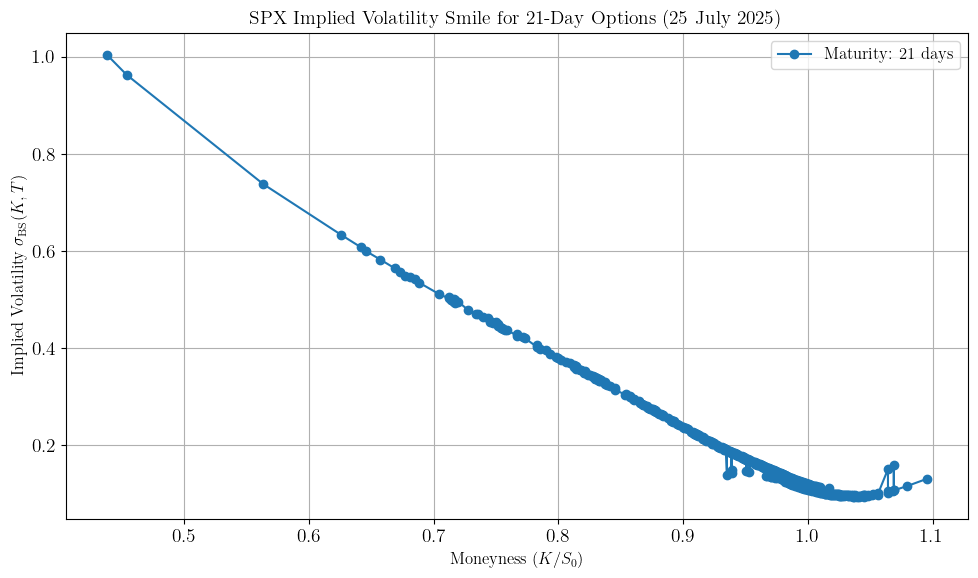

In [9]:
# --- Step 5: Visualize the Volatility Smile ---

# First, let's find the maturity that has the most options available in our dataset.
# This will likely be a standard, liquid expiration date.
# We need to convert the expiration dates back from time_to_maturity for this.
# Let's find the most common 'time_to_maturity' value.
most_common_maturity = final_surface_df['time_to_maturity'].mode()[0]
print(f"The most common maturity in the dataset is {most_common_maturity*365:.0f} days away. Plotting smile for this maturity.")

# Filter the DataFrame to get only the options for this specific maturity.
smile_df = final_surface_df[final_surface_df['time_to_maturity'] == most_common_maturity].copy()

print(f"We are seeing the smile for {len(smile_df)} options on this maturity.")

# For a better plot, it's common to use 'moneyness' (Strike / Spot) on the x-axis.
smile_df['moneyness'] = smile_df['strike'] / spot_price

# Sort the values by strike price to ensure the line plot connects points correctly.
smile_df = smile_df.sort_values(by='strike')

# --- Plotting ---

# Create a plot figure and axes
plt.figure(figsize=(10, 6))

# Plot the implied volatility against moneyness
# We use a line plot to see the 'smile' shape and scatter to see the individual data points
plt.plot(smile_df['moneyness'], smile_df['implied_vol'], marker='o', linestyle='-', label=f'Maturity: {most_common_maturity*365:.0f} days')
# plt.scatter(smile_df['moneyness'], smile_df['implied_vol'], label='Data Points')


# Add titles and labels for clarity
plt.title(r'SPX Implied Volatility Smile for ' + f'{most_common_maturity*365:.0f}' + r'-Day Options (25 July 2025)', fontsize=14)
plt.xlabel(r'Moneyness ($K/S_0$)', fontsize=12)
plt.ylabel(r'Implied Volatility $\sigma_{\mathrm{BS}}(K, T)$', fontsize=12)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("spx_iv_smile_25july2025.png", dpi=600, bbox_inches='tight')
plt.show()

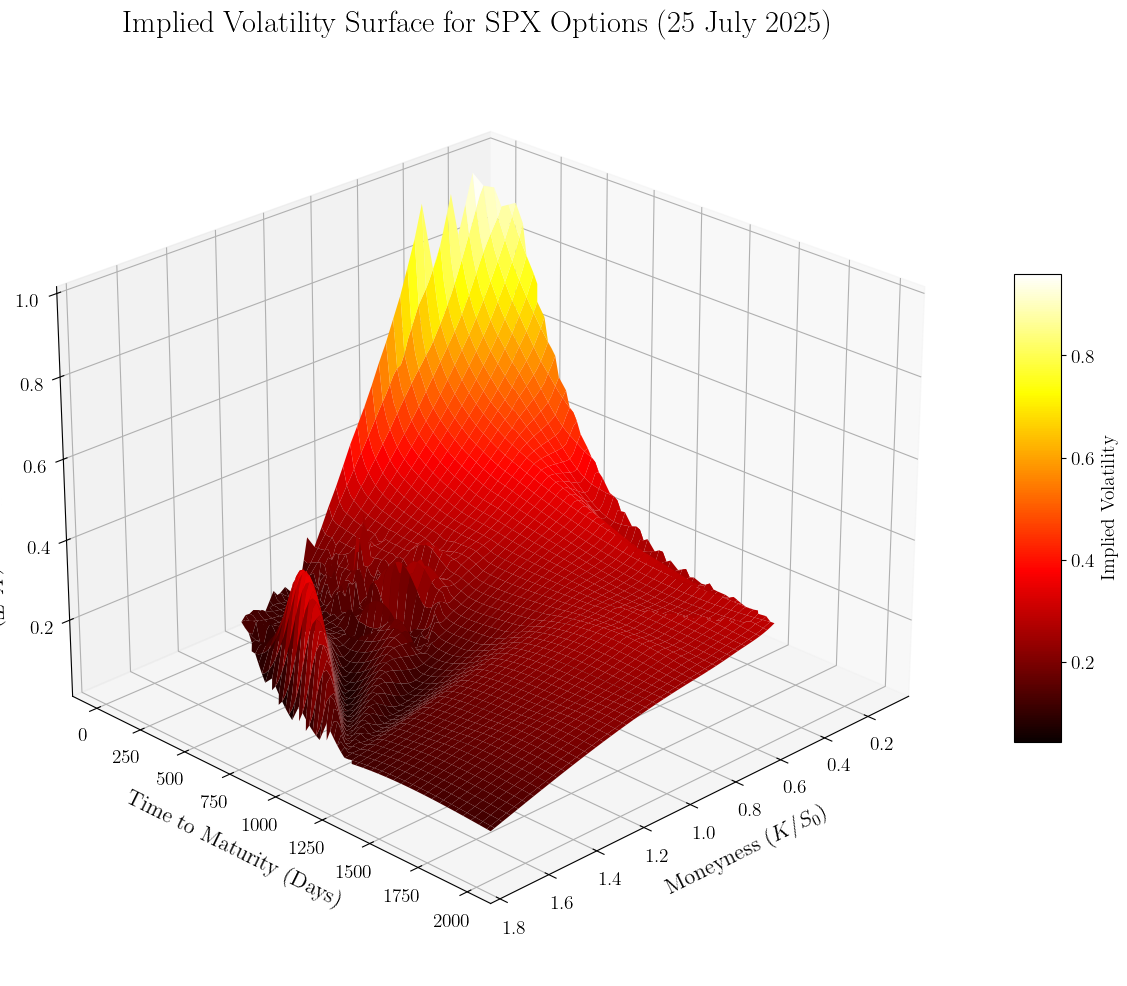


SUCCESS: 3D surface plot generated and saved as 'smooth_surface_3d.png'


In [63]:
# --- 3D Surface Plot ---
    
# Prepare data for interpolation with the axes.
# X will now be Moneyness, Y will be Time to Maturity, and Z is Implied Vol.
x_data = (final_surface_df['strike'] / spot_price).values
y_data = final_surface_df['time_to_maturity'].values
z_data = final_surface_df['implied_vol'].values
    
# Create a regular grid of points to interpolate the scattered data onto.
x_grid_new = np.linspace(min(x_data), max(x_data), 100)
y_grid_new = np.linspace(min(y_data), max(y_data), 100)
X_grid_new, Y_grid_new = np.meshgrid(x_grid_new, y_grid_new)
    
# Interpolate the Z values (implied vol) onto the new grid using cubic interpolation for a smooth surface.
Z_grid_new = griddata((x_data, y_data), z_data, (X_grid_new, Y_grid_new), method='cubic')
    
# --- Plotting ---

# Create the figure and a 3D subplot.
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111, projection='3d')
    
# Set the background color of the plot and the surrounding figure to white for a clean look.
ax.set_facecolor('white')
fig.patch.set_facecolor('white')

# Plot the smooth surface using the interpolated grid data.
# The colormap 'hot' is used, and Y is multiplied by 365 to show days.
surface = ax.plot_surface(X_grid_new, Y_grid_new * 365, Z_grid_new, cmap='hot', edgecolor='none')
    
# Set the main title and axis labels for the plot.
ax.set_title(r'Implied Volatility Surface for SPX Options (25 July 2025)', fontsize=22, pad=5)
ax.set_xlabel(r'Moneyness $(K/S_0)$', fontsize=16, labelpad=10)
ax.set_ylabel(r'Time to Maturity (Days)', fontsize=16, labelpad=10)
ax.set_zlabel(r'Implied Volatility $\sigma_{\mathrm{BS}}(K,T)$', fontsize=16, labelpad=10)
    
# Adjust the viewing angle (elevation and azimuth) for a better perspective.
ax.view_init(elev=25, azim=45)
    
# Add a color bar to serve as a legend for the implied volatility values.
fig.colorbar(surface, shrink=0.5, aspect=10, label='Implied Volatility')

# This gives more direct control over the margins than tight_layout() for 3D plots.
# left, right, top, bottom are fractions of the figure width and height.
fig.subplots_adjust(left=0.05, right=0.9, top=0.83, bottom=0.05)
    
# Save the generated figure to a file and close the plot to free memory.
plt.savefig('smooth_surface_3d.png', dpi=600)

# Show the plot
plt.show()

print("\nSUCCESS: 3D surface plot generated and saved as 'smooth_surface_3d.png'")

## **Comparison Between The Given Implied Volatility and The Calculated Implied Volatility**

--- Loading Provider's Data ---
Provider's data loaded. Contains 25208 rows.

--- Merging and Comparing Datasets ---
Successfully merged. Comparing 5408 common options.

--- Numerical Comparison Results ---
Difference Statistics (Custom IV - Provider IV):
count    5408.000000
mean       -0.002092
std         0.008636
min        -0.088281
25%        -0.005401
50%        -0.002143
75%         0.002891
max         0.061839
Name: difference, dtype: float64

--- Generating Visual Comparison Plot ---


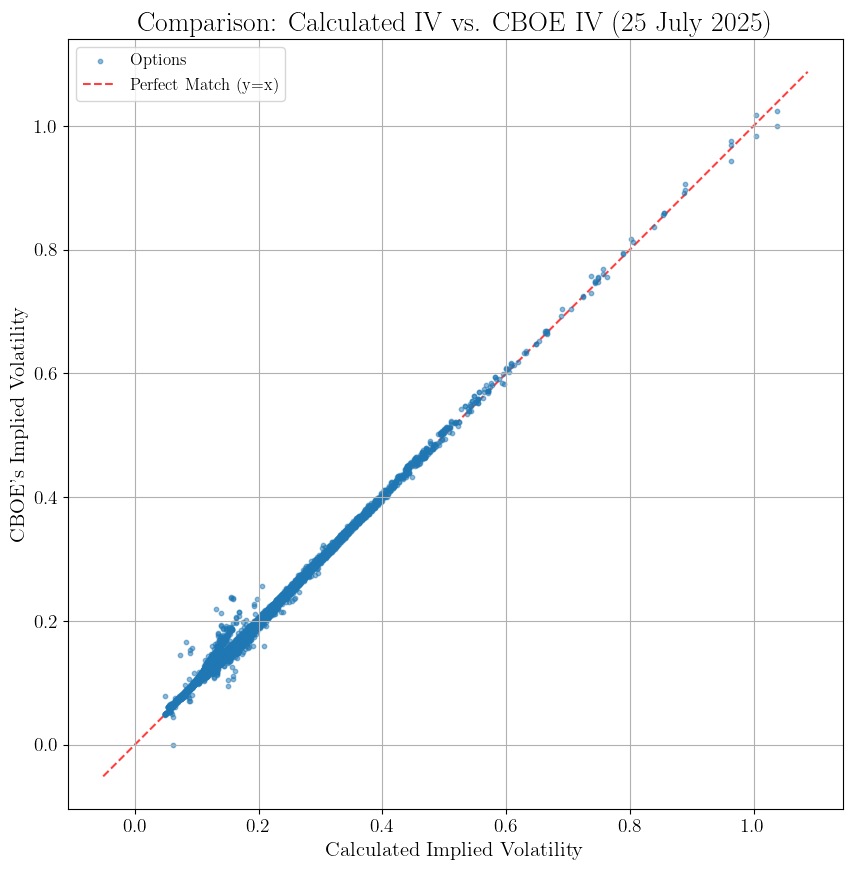


SUCCESS: Comparison plot displayed and saved as 'iv_true_comparison.png'


In [82]:
print("--- Loading Provider's Data ---")
# Define the file path for the data provider's file, which includes their IV calculations.
calcs_file = 'UnderlyingOptionsEODCalcs_2025-07-25.csv'
# Load the data into a pandas DataFrame.
df_provider = pd.read_csv(calcs_file)
    
# Select only the essential columns for the comparison: the option identifiers
# (expiration, strike, type) and the provider's implied volatility column.
# A .copy() is used to avoid SettingWithCopyWarning.
provider_df = df_provider[['expiration', 'strike', 'option_type', 'implied_volatility_1545']].copy()
# Rename the provider's IV column to 'iv_provider' for clarity during the merge.
provider_df = provider_df.rename(columns={'implied_volatility_1545': 'iv_provider'})

# Ensure the 'expiration' column is converted to datetime objects. This is crucial
# for the merge operation to work correctly, as it standardizes the key format.
provider_df['expiration'] = pd.to_datetime(provider_df['expiration'])
print(f"Provider's data loaded. Contains {len(provider_df)} rows.")

# --- Merge Our Calculations with the CBOE Data ---

print("\n--- Merging and Comparing Datasets ---")

# Rename your calculated IV column from 'implied_vol' to 'iv_custom'.
# This is done on the 'final_surface_df' DataFrame, which is assumed to be in memory
# from your previous script runs. This prevents column name conflicts.
final_surface_df = final_surface_df.rename(columns={'implied_vol': 'iv_custom'})

# Merge your calculated data with the provider's data.
# The 'on' parameter specifies the columns to use as keys for the merge. An option is
# uniquely identified by its expiration, strike, and type.
comparison_df = pd.merge(
    final_surface_df[['expiration', 'strike', 'option_type', 'iv_custom']],
    provider_df,
    on=['expiration', 'strike', 'option_type']
)
print(f"Successfully merged. Comparing {len(comparison_df)} common options.")
    
# Calculate the difference between your calculation and the provider's.
# A new 'difference' column is created to store this value for each option.
comparison_df['difference'] = comparison_df['iv_custom'] - comparison_df['iv_provider']

# --- Analyze and Visualize the Comparison ---

# Numerical Comparison
print("\n--- Numerical Comparison Results ---")
# Use the .describe() method on the 'difference' column to get key statistics:
# count, mean, standard deviation, min, max, and quartiles.
print("Difference Statistics (Custom IV - Provider IV):")
print(comparison_df['difference'].describe())
    
# Visual Comparison
print("\n--- Generating Visual Comparison Plot ---")
# Create a new figure for the plot with a specified size.
plt.figure(figsize=(10, 10))
# Create a scatter plot with your IV on the x-axis and the provider's IV on the y-axis.
# 'alpha' makes the points semi-transparent to show areas of high density.
plt.scatter(comparison_df['iv_custom'], comparison_df['iv_provider'], alpha=0.5, s=10, label='Options')
    
# Add a diagonal y=x line to represent a perfect match.
# First, find the min and max limits for both axes to define the line's start and end.
lims = [
    np.min([plt.xlim(), plt.ylim()]),
    np.max([plt.xlim(), plt.ylim()]),
]
# Plot the red dashed line ('r--') using the calculated limits.
plt.plot(lims, lims, 'r--', alpha=0.75, zorder=0, label='Perfect Match (y=x)')
    
# Add titles and labels to make the plot informative.
plt.title(r'Comparison: Calculated IV vs. CBOE IV (25 July 2025)', fontsize=20)
plt.xlabel(r'Calculated Implied Volatility', fontsize=15)
plt.ylabel(r"CBOE's Implied Volatility", fontsize=15)
plt.grid(True)
plt.legend()
# Set the aspect ratio of the plot to be equal, ensuring the y=x line is at a true 45-degree angle.
plt.axis('equal')
plt.savefig('iv_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()
    
print("\nSUCCESS: Comparison plot displayed and saved as 'iv_comparison.png'")

95th percentile error: 0.016389714019032255


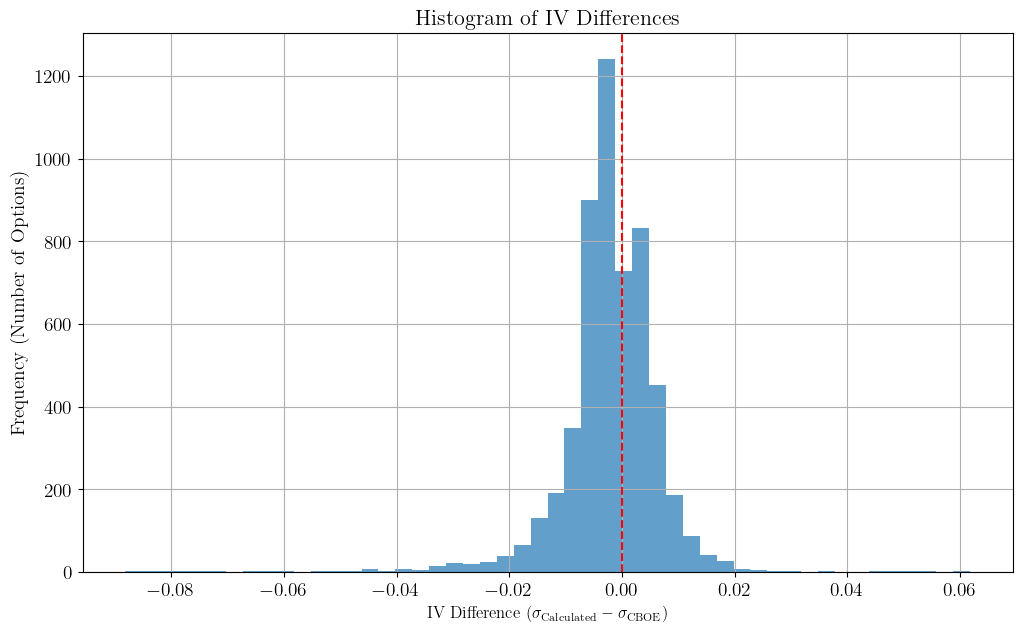

In [96]:
plt.figure(figsize=(12, 7))
# Calculate the absolute error to measure the magnitude of the difference, regardless of direction.
comparison_df['abs_error'] = np.abs(comparison_df['difference'])

# Calculate and print the 95th percentile of the absolute error.
# This metric shows the error margin that covers 95% of the comparisons.
print("95th percentile error:", comparison_df['abs_error'].quantile(0.95))

# Create a histogram to visualize the distribution of the differences.
# 'bins=50' creates 50 intervals for the data. 'alpha=0.7' makes the bars semi-transparent.
plt.hist(comparison_df['difference'], bins=50, alpha=0.7)

# Add a vertical red dashed line at x=0 to represent the point of zero difference.
plt.axvline(x=0, color='r', linestyle='--')

# Add titles and labels to the histogram.
plt.title(r'Histogram of IV Differences',fontsize=16)
plt.xlabel(r'IV Difference $(\sigma_{\mathrm{Calculated}} - \sigma_{\mathrm{CBOE}})$', fontsize=12)
plt.ylabel(r'Frequency (Number of Options)')
plt.grid(True)

plt.savefig('iv_difference_histogram.png', dpi=600)
plt.show()
plt.close()


--- Generating Histogram by Option Type ---


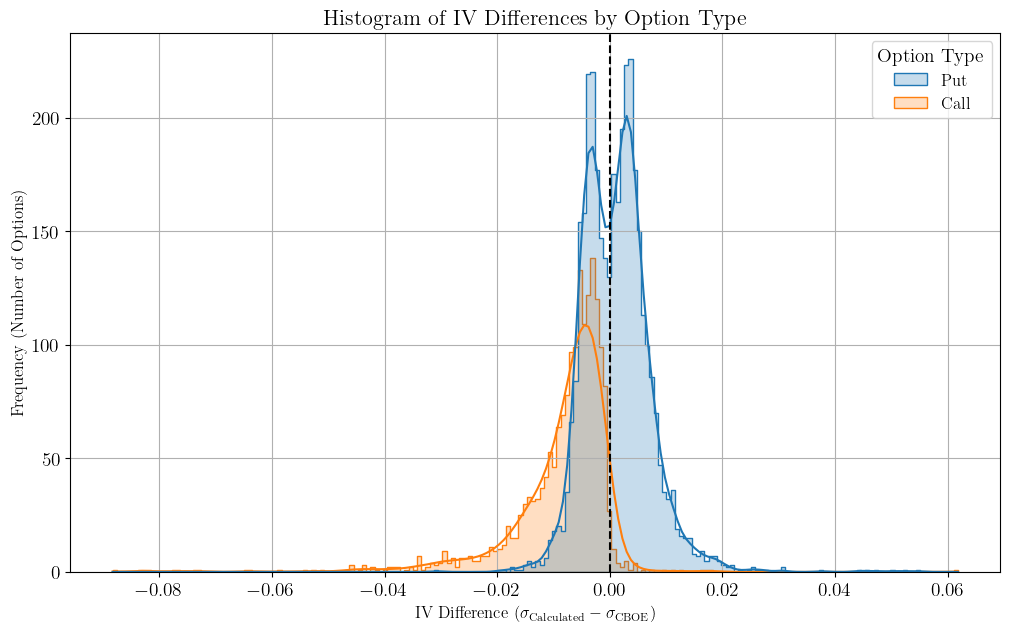


SUCCESS: Histogram by option type saved as 'iv_difference_histogram_by_type.png'


In [97]:
print("\n--- Generating Histogram by Option Type ---")
plt.figure(figsize=(12, 7))

# Create a new column with full names ('Call', 'Put') for a cleaner legend.
# This is the most robust way to control legend titles and labels in seaborn.
comparison_df['Option Type'] = comparison_df['option_type'].map({'C': 'Call', 'P': 'Put'})

# Create a histogram using seaborn, now using the new 'Option Type' column for the 'hue'.
# This will automatically create a legend with the title 'Option Type' and labels 'Call' and 'Put'.
sns.histplot(data=comparison_df, x='difference', hue='Option Type', bins=200, kde=True, element='step')

# Add a vertical line at zero for reference.
plt.axvline(x=0, color='black', linestyle='--')

# Add titles and labels, using LaTeX formatting for consistency.
plt.title('Histogram of IV Differences by Option Type', fontsize=16)
plt.xlabel(r'IV Difference $(\sigma_{\mathrm{Calculated}} - \sigma_{\mathrm{CBOE}})$', fontsize=12)
plt.ylabel('Frequency (Number of Options)', fontsize=12)
plt.grid(True)

# Save and show the plot.
plt.savefig('iv_difference_histogram_by_type.png', dpi=600)
plt.show()
plt.close()

print("\nSUCCESS: Histogram by option type saved as 'iv_difference_histogram_by_type.png'")